In [5]:
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]* x_train.shape[2])

print('Train Shape:',x_train.shape)
print('Class Shape:',y_train.shape)

Train Shape: (60000, 784)
Class Shape: (60000,)


(60000, 784)
(60000, 2)


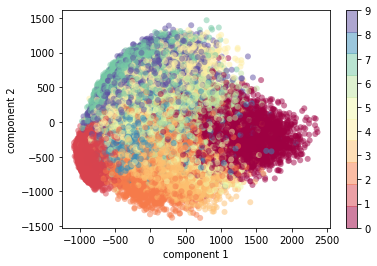

In [4]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(x_train)
print(x_train.shape)
print(projected.shape)

plt.scatter(projected[:, 0],projected[:, 1], #[0 for i in range(len(projected))]
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [10]:
kmeans = KMeans(n_clusters=10)  
kmeans.fit(projected)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [16]:
clusters = kmeans.cluster_centers_
print(clusters)
print(len(kmeans.labels_))

[[ 114.29395281   -2.16033828]
 [-858.40516134 -471.68096594]
 [ -94.86431449  750.48096974]
 [ 683.01558769  -83.98283951]
 [ 419.72922058 -633.34025345]
 [ 405.15808742  737.99313122]
 [-496.70453452  -89.28935339]
 [1350.4846015  -243.97831094]
 [-135.5548715  -492.1681482 ]
 [-411.37200697  422.06465648]]
60000


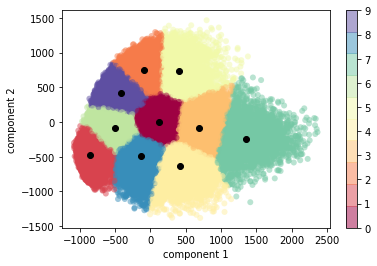

In [25]:
plt.scatter(projected[:,0],projected[:, 1],
            c=kmeans.labels_, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')  